# Importing Neural Networks into OMLT

This notebook shows how to import your neural networks into OMLT.

OMLT includes an importer for neural networks saved as [ONNX](https://onnx.ai/). This notebook shows you how to save neural networks into ONNX from a number of popular machine learning libraries. Finally, we show how to import the ONNX file into OMLT.

## Library Setup
This notebook assumes you have a working Tensorflow/Keras and PyTorch environments to train the neural network for classification. The neural network is then formulated in Pyomo using OMLT which therefore requires working Pyomo and OMLT installations.

The required Python libraries used this notebook are as follows: <br>
- `pandas`: used to manipulate input data <br>
- `numpy`: used for manipulate input data <br>
- `matplotlib`: used to make plots
- `tensorflow`: the machine learning language we use to train our neural network
- `pytorch`: the machine learning language we use to train our neural network
- `tf2onnx`: used to import trained Tensorflow models to ONNX
- `pyomo`: the algebraic modeling language for Python, it is used to define the optimization model passed to the solver
- `omlt`: the package this notebook demonstates. OMLT can formulate machine learning models (such as neural networks) within Pyomo

Throughout this notebook we are going to use Pima Indians Diabetes dataset to train a neural network that predicts whether or not a patient has diabetes, based on a set of medical data. This dataset is from the National Institute of Diabetes and Digestive and Kidney Diseases [0], licensed under the CC0 (Public Domain) license.
You can find more information about this dataset on [Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database).

We start by importing the data into a Pandas dataframe.

In [1]:
import pandas as pd

df = pd.read_csv("../data/diabetes.csv")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


We then visualize the distribution of column values.

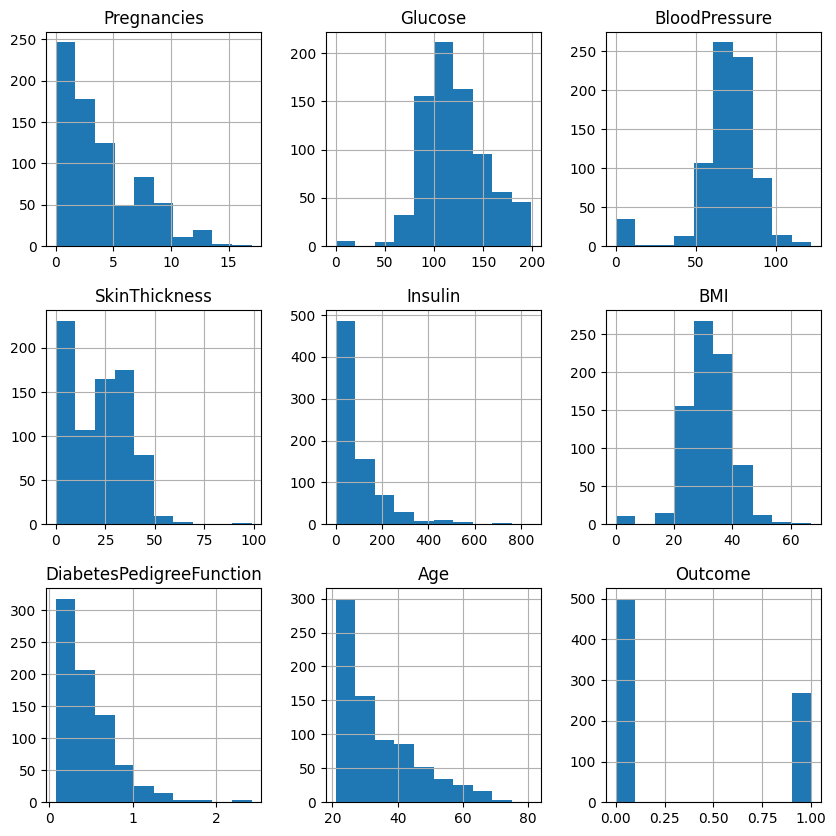

In [2]:
_ = df.hist(figsize=(10, 10))

Finally we split the data into input and output variables

In [3]:
X = df.iloc[:, :8].to_numpy()
Y = df.iloc[:, 8].to_numpy()

## Storing variables bounds

When developing optimization models is important to define bounds on variables. If the neural network includes ReLU activation functions, then OMLT requires all input variables to be bounded to produce a tighter MIP formulation of the ReLU activations.

OMLT includes a function to write the input bounds in a format that can be read back later together with the ONNX model.

We start by computing bounds on the eight input variables of our simple neural networks. We will use `input_bounds` later when we save the ONNX model.

In [4]:
import numpy as np

lb = np.min(X, axis=0)
ub = np.max(X, axis=0)
input_bounds = list(zip(lb, ub))
input_bounds

[(0.0, 17.0),
 (0.0, 199.0),
 (0.0, 122.0),
 (0.0, 99.0),
 (0.0, 846.0),
 (0.0, 67.1),
 (0.078, 2.42),
 (21.0, 81.0)]

We import the function used to write the ONNX model together with its bounds.

In [5]:
from omlt.io import load_onnx_neural_network_with_bounds, write_onnx_model_with_bounds

2024-05-16 17:23:43.060702: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 17:23:43.107094: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


You can visualize the neural network ONNX model using an app like [Netron](https://netron.app/).

These functions are only used in the notebooks and are not related to ONNX or OMLT.

In [6]:
import tempfile

from IPython.display import Image

## Keras


We start by building a simple Keras model with 3 dense layers. 

In [7]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # or any {'0', '1', '2'}
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()
model.add(Dense(12, input_dim=8, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


We then fit the model to the dataset

In [8]:
model.fit(X, Y, epochs=150, batch_size=10)

Epoch 1/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6556 - loss: 5.5503
Epoch 2/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6514 - loss: 5.6185
Epoch 3/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6416 - loss: 5.7775
Epoch 4/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6579 - loss: 5.5142
Epoch 5/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6483 - loss: 5.6692
Epoch 6/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6317 - loss: 5.9365
Epoch 7/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6459 - loss: 5.7081
Epoch 8/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6452 - loss: 5.7192
Epoch 9/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6770 - loss: 5.2058
Epoch 10/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6290 - loss: 5.9799
Epoch 11/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6771 - loss: 5.2039
Epoch 12/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

We can now export the Keras model to ONNX.

In [9]:
# Add output_names for compatibility:
model.output_names = [output.name for output in model.outputs]

import tf2onnx
from tensorflow import TensorSpec

spec = [TensorSpec(input.shape, input.dtype, input.name) for input in model.inputs]
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec)

with tempfile.NamedTemporaryFile(suffix=".onnx", delete=False) as f:
    write_onnx_model_with_bounds(f.name, onnx_model, input_bounds)
    print(f"Wrote ONNX model with bounds at {f.name}")

2024-05-16 17:24:23.814799: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-05-16 17:24:23.814932: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-16 17:24:23.911262: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-05-16 17:24:23.911400: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


Wrote ONNX model with bounds at /tmp/tmpz_5cafcg.onnx


The model after serialization looks like the following:

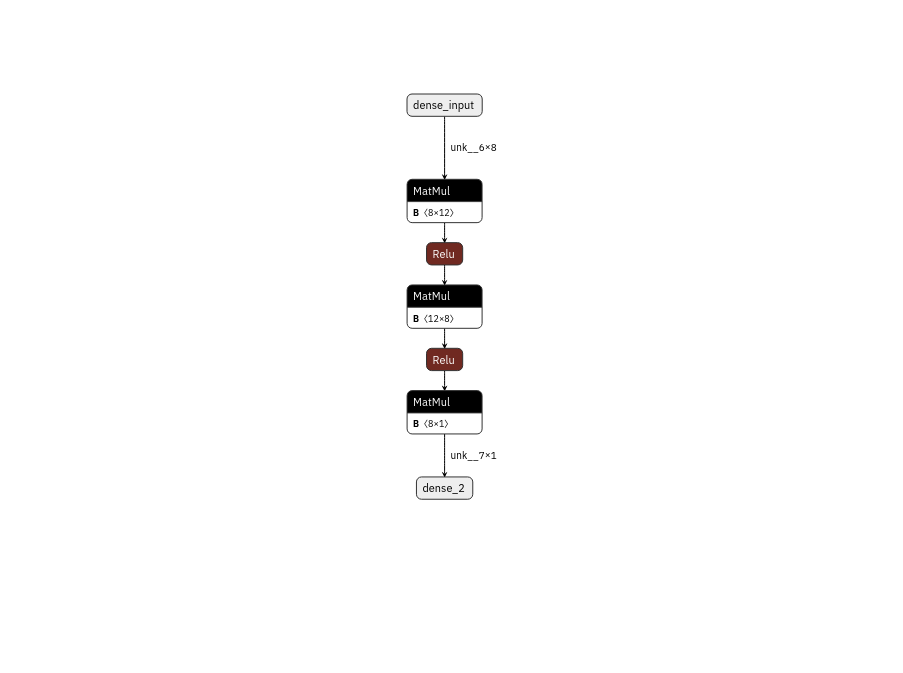

In [10]:
Image(filename="../images/simple-neural-network.png", height=600)

## PyTorch

We start by building a simple model using the PyTorch API.

In [11]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, TensorDataset


class PyTorchModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense_0 = nn.Linear(8, 12)
        self.dense_1 = nn.Linear(12, 1)
        self.out = nn.Linear(1, 1)

    def forward(self, x):
        x = F.relu(self.dense_0(x))
        x = F.relu(self.dense_1(x))
        return self.out(x)


model = PyTorchModel()
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

dataset = TensorDataset(
    torch.as_tensor(X, dtype=torch.float32), torch.as_tensor(Y, dtype=torch.float32)
)
dataloader = DataLoader(dataset, batch_size=10)

for epoch in range(150):
    for x_batch, y_batch in dataloader:
        y_batch_pred = model(x_batch)
        loss = loss_function(y_batch_pred, y_batch.view(*y_batch_pred.shape))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch number: {epoch} loss : {loss.item()}")

Epoch number: 0 loss : 0.2537655234336853
Epoch number: 10 loss : 0.251478910446167
Epoch number: 20 loss : 0.2516653537750244
Epoch number: 30 loss : 0.2530170977115631
Epoch number: 40 loss : 0.25084957480430603
Epoch number: 50 loss : 0.2542480528354645
Epoch number: 60 loss : 0.25108495354652405
Epoch number: 70 loss : 0.25102800130844116
Epoch number: 80 loss : 0.2500641345977783
Epoch number: 90 loss : 0.2532801032066345
Epoch number: 100 loss : 0.2516343593597412
Epoch number: 110 loss : 0.2513783872127533
Epoch number: 120 loss : 0.25228577852249146
Epoch number: 130 loss : 0.2504936456680298
Epoch number: 140 loss : 0.2519592344760895


We can now export the PyTorch model to ONNX. Notice that we need to specify that the first axis of the input should be ignored since it represent training batches. Also notice that PyTorch write the ONNX model directly to the specified file, so we don't pass the raw ONNX model to `write_onnx_model_with_bounds` and instead we only specify the bounds.

In [12]:
import torch.onnx

# model input used for exporting
x = torch.randn(10, 8, requires_grad=True)
pytorch_model = None
with tempfile.NamedTemporaryFile(suffix=".onnx", delete=False) as f:
    torch.onnx.export(
        model,
        x,
        f,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    )
    write_onnx_model_with_bounds(f.name, None, input_bounds)
    print(f"Wrote PyTorch model to {f.name}")
    pytorch_model = f.name

Wrote PyTorch model to /tmp/tmpnl9ub4y3.onnx


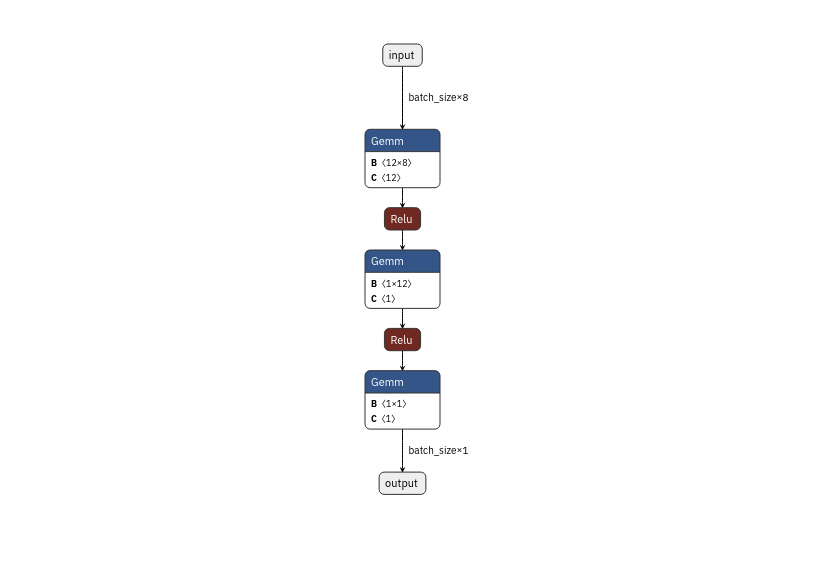

In [13]:
Image(filename="../images/torch-neural-network.png", height=500)

## Importing ONNX into OMLT

Finally, we can import the ONNX model and bounds into OMLT.

In [14]:
network_definition = load_onnx_neural_network_with_bounds(pytorch_model)

The network definition includes the bounds we defined at the beginning of this notebook.

In [15]:
network_definition.scaled_input_bounds

{0: (0.0, 17.0),
 1: (0.0, 199.0),
 2: (0.0, 122.0),
 3: (0.0, 99.0),
 4: (0.0, 846.0),
 5: (0.0, 67.1),
 6: (0.078, 2.42),
 7: (21.0, 81.0)}

We can iterate over the layers to print their input and output shape, together with the activation function.

In [16]:
for layer_id, layer in enumerate(network_definition.layers):
    print(f"{layer_id}\t{layer}\t{layer.activation}")

0	InputLayer(input_size=[8], output_size=[8])	linear
1	DenseLayer(input_size=[8], output_size=[12])	relu
2	DenseLayer(input_size=[12], output_size=[1])	relu
3	DenseLayer(input_size=[1], output_size=[1])	linear


## References

[0] Smith, Jack W., et al. "Using the ADAP learning algorithm to forecast the onset of diabetes mellitus." Proceedings of the annual symposium on computer application in medical care. American Medical Informatics Association, 1988.